# 01 - BigQuery - Table Data Source
Use BigQuery to load and prepare data for machine learning:

### Video Walkthrough of this notebook:
Includes conversational walkthrough and more explanatory information than the notebook:

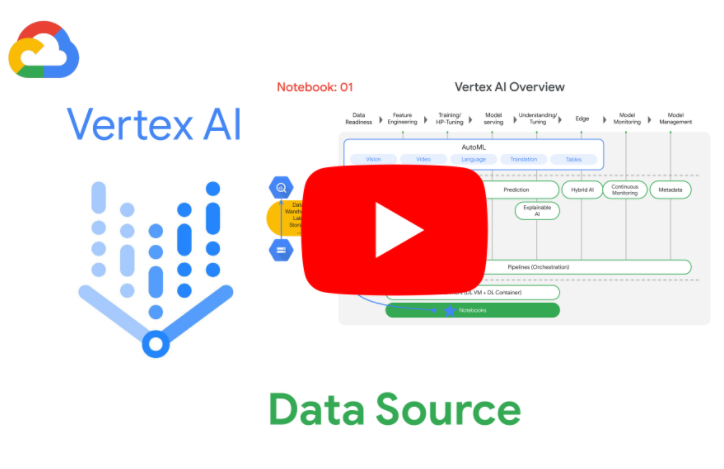

### Prerequisites:
-  00 - Environment Setup

### Overview:
-  Setup BigQuery
   -  Create a Dataset
      -  Use BigQuery Python Client
   -  Create Tables
      -  Copy from another Project:Dataset
         -  SQL with BigQuery Jupyter Magic (%%bigquery)
      -  Load data from GCS Bucket
         -  BigQuery Python Client (load_table_from_uri)
   -  Prepare Data For Analysis
      -  Run SQL Queries to prepare Unique ID's and Train/Test Splits

### Resources:
-  [Python Client For Google BigQuery](https://googleapis.dev/python/bigquery/latest/index.html)
-  [Download BigQuery Data to Pandas](https://cloud.google.com/bigquery/docs/bigquery-storage-python-pandas)
-  [BigQuery Template Notebooks](https://github.com/GoogleCloudPlatform/bigquery-notebooks/tree/main/notebooks/official/template_notebooks)



---
## Vertex AI - Conceptual Flow

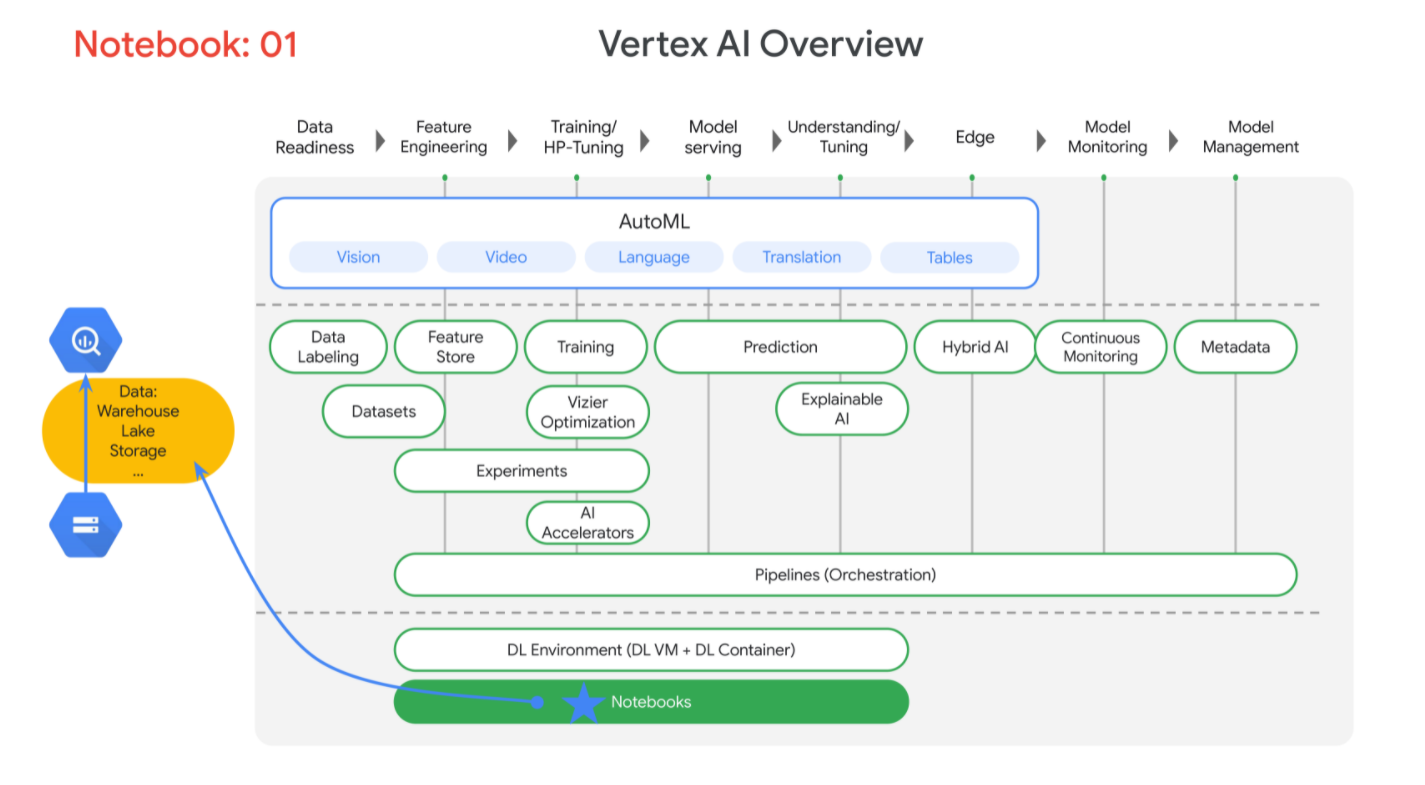

---
## Vertex AI - Workflow


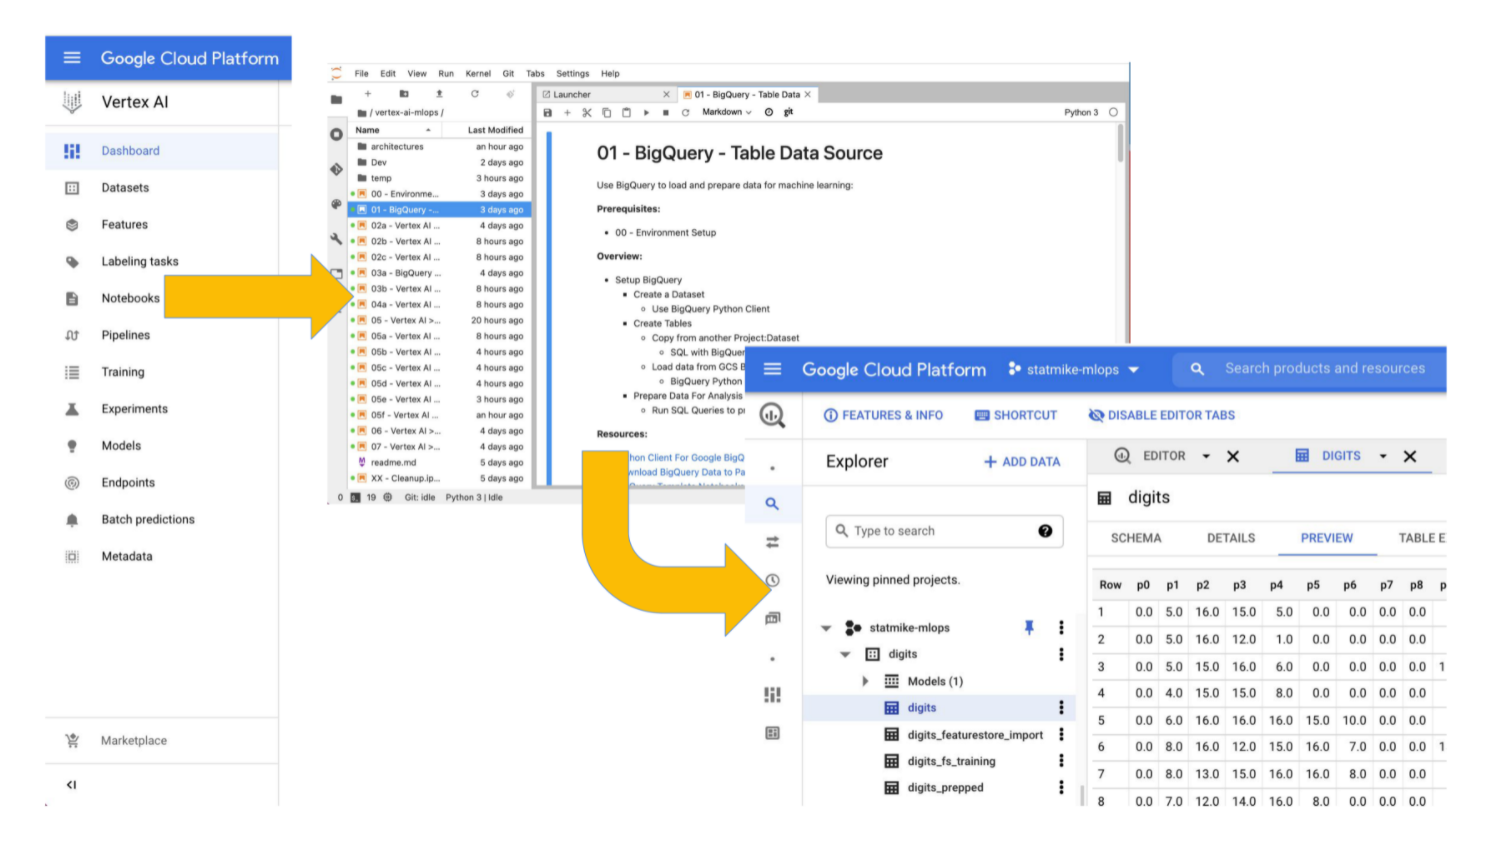

---
## Source Data

**Overview**

This notebook imports source data for this project into Google BigQuery.  All the remaining notebooks utilize BigQuery as the source and leverage API's native to the machine learning approaches they feature.

In the enviornment setup notebook (00), a BigQuery source table was exported to CSV format in a Cloud Storage Bucket. This notebook, `01 - BigQuery - Table Data Source`, start the machine learning lifecycle by importing a source and preparing it for machine learning.  To customize this series of notebooks change the source referenced here or in notebook `00 - Environment Setup`.

All of these workflows utilize tabular data to fit a supervised learning model: predict a target variable by learning patterns in feature columns.  The type of supervised learning used in these projects is classification: models with a target variable that has multiple discrete classes.  

**The Data**

The source data is exported to Google Cloud Storage in CSV format by the `00 - Environment Setup` notebook.  The BigQuery source table is `bigquery-public-data.ml_datasets.ulb_fraud_detection`.  This is a table of credit card transactions that are classified as fradulant, `Class = 1`, or normal `Class = 0`.  

The data can be researched further at this [Kaggle link](https://www.kaggle.com/mlg-ulb/creditcardfraud).

**Description of the Data**

This is a table of 284,207 credit card transactions classified as fradulant or normal in the column `Class`.  In order protect confidentiality, the original features have been transformed using [principle component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) into 28 features named `V1, V2, ... V28` (float).  Two descriptive features are provided without transformation by PCA:
- `Time` (integer) is the seconds elapsed between the transaction and the earliest transaction in the table
- `Amount` (float) is the value of the transaction
>**Quick Note on PCA**

>PCA is an unsupervised learning technique: there is not a target variable.  PCA is commonlly used as a variable/feature reduction technique.  If you have 100 features then you could reduce it to a number p (say 10) projected features.  The choice of this number is a balance of how well it can explain the variance of the full feature space and reducing the number of features.  Each projected feature is orthogonal to each other feature, meaning there is no correlation between these new projected features.

**Preparation of the Data**

This notebook adds two columns to the source data and stores it in a new table with suffix `_prepped`.  
- `transaction_id` (string) a unique id for the row/transaction
- `splits` (string) this divided the tranactions into sets for `TRAIN` (80%), `VALIDATA` (10%), and `TEST` (10%)

---
## Setup

inputs:

In [5]:
PROJECT_ID = "statmike-mlops"
REGION = 'us-central1'
PROJECT_ID = 'ma-mx-presales-lab'
DATANAME = 'fraud'
NOTEBOOK = '01'

packages:

In [3]:
from google.cloud import bigquery

clients:

In [4]:
bq = bigquery.Client(project = PROJECT_ID)

parameters:

In [6]:
BUCKET = "vertex-ai-mlops-bucket"

---
## Create Dataset

List BigQuery datasets in the project:

In [7]:
query = f"""
SELECT schema_name
FROM `{PROJECT_ID}.INFORMATION_SCHEMA.SCHEMATA`
"""

bq.query(query = query).to_dataframe()

,schema_name
0,Recommendation_online_retail
1,Recommendation_AI_ga360
2,online_retail
3,fraud_detection
4,business_analytics_online_retail
5,bqmlforecast


Create the dataset if missing:

In [8]:
query = f"""
CREATE SCHEMA IF NOT EXISTS `{PROJECT_ID}.{DATANAME}`
OPTIONS(
    location = '{REGION}',
    labels = [('notebook','{NOTEBOOK}')]
)
"""
job = bq.query(query = query)
job.result()

In [9]:
(job.ended-job.started).total_seconds()

0.498

---
## Create Table
- import data from Cloud Storage Bucket
- https://cloud.google.com/bigquery/docs/loading-data-cloud-storage-csv

In [10]:
destination = bigquery.TableReference.from_string(f"{PROJECT_ID}.{DATANAME}.{DATANAME}")

job_config = bigquery.LoadJobConfig(
    write_disposition = 'WRITE_TRUNCATE',
    source_format = bigquery.SourceFormat.CSV,
    autodetect = True,
    labels = {'notebook':f'{NOTEBOOK}'}
)

job = bq.load_table_from_uri(f"gs://{BUCKET}/{DATANAME}/data/{DATANAME}.csv", destination, job_config = job_config)
job.result()

LoadJob<project=ma-mx-presales-lab, location=us-central1, id=5ad7e6d4-9f80-43ed-b3de-bde376b9f50d>

In [11]:
(job.ended-job.started).total_seconds()

11.252

In [12]:
query = f"""
SELECT *
FROM `{DATANAME}.{DATANAME}`
LIMIT 5
"""
bq.query(query = query).to_dataframe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,282,-0.356466,0.725418,1.971749,0.831343,0.369681,-0.107776,0.751610,-0.120166,-0.420675,...,0.020804,0.424312,-0.015989,0.466754,-0.809962,0.657334,-0.043150,-0.046401,0.0,0
1,380,-1.299837,0.881817,1.452842,-1.293698,-0.025105,-1.170103,0.861610,-0.193934,0.592001,...,-0.272563,-0.360853,0.223911,0.598930,-0.397705,0.637141,0.234872,0.021379,0.0,0
2,403,1.237413,0.512365,0.687746,1.693872,-0.236323,-0.650232,0.118066,-0.230545,-0.808523,...,-0.077543,-0.178220,0.038722,0.471218,0.289249,0.871803,-0.066884,0.012986,0.0,0
3,430,-1.860258,-0.629859,0.966570,0.844632,0.759983,-1.481173,-0.509681,0.540722,-0.733623,...,0.268028,0.125515,-0.225029,0.586664,-0.031598,0.570168,-0.043007,-0.223739,0.0,0
4,711,-0.431349,1.027694,2.670816,2.084787,-0.274567,0.286856,0.152110,0.200872,-0.596505,...,0.001241,0.154170,-0.141533,0.384610,-0.147132,-0.087100,0.101117,0.077944,0.0,0


### Check out this table in BigQuery Console:
- Click: https://console.cloud.google.com/bigquery
- Make sure project selected is the one from this notebook
- Under Explore, expand this project and review the dataset and table

---
## Review Data
Additional SQL queries could be used to review the data.  This section shows moving the table to a Pandas dataframe for local review in Python:

In [13]:
query = f"""
SELECT *
FROM `{DATANAME}.{DATANAME}`
"""
df = bq.query(query = query).to_dataframe()

In [14]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [15]:
df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

---
## Prepare Data for Analysis

Create a prepped version of the data with test/train splits using SQL DDL:

In [16]:
query = f"""
CREATE OR REPLACE TABLE `{DATANAME}.{DATANAME}_prepped` AS
WITH add_id AS(SELECT *, GENERATE_UUID() AS transaction_id FROM `{DATANAME}.{DATANAME}`)
SELECT *,
    CASE 
        WHEN MOD(ABS(FARM_FINGERPRINT(transaction_id)),10) < 8 THEN "TRAIN" 
        WHEN MOD(ABS(FARM_FINGERPRINT(transaction_id)),10) < 9 THEN "VALIDATE"
        ELSE "TEST"
    END AS splits
FROM add_id
"""
job = bq.query(query = query)
job.result()

In [17]:
(job.ended-job.started).total_seconds()

7.785

In [18]:
job.estimated_bytes_processed/1000000 #MB

70.632136

Review the test/train split:

In [21]:
query = f"""
SELECT splits, count(*) as Count, 100*count(*) / (sum(count(*)) OVER()) as Percentage
FROM `{DATANAME}.{DATANAME}_prepped`
GROUP BY splits
"""
bq.query(query = query).to_dataframe()

,splits,Count,Percentage
0,VALIDATE,28449,9.988870
1,TEST,28468,9.995541
2,TRAIN,227890,80.015590


Retrieve a subset of the data to a Pandas dataframe:

In [23]:
query = f"""
SELECT * 
FROM `{DATANAME}.{DATANAME}_prepped`
LIMIT 5
"""
data = bq.query(query = query).to_dataframe()

In [24]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,transaction_id,splits
0,6126,-0.130702,1.026568,2.692793,2.659141,0.764928,1.800330,0.317986,-0.392976,0.851460,...,-0.370958,-1.058635,-0.498915,0.054906,-0.590204,-0.537678,0.0,0,70526fff-bdf3-459f-bbc6-a18e8133bb35,TEST
1,32799,1.153477,-0.047859,1.358363,1.480620,-1.222598,-0.481690,-0.654461,0.128115,0.907095,...,-0.025964,0.701843,0.417245,-0.257691,0.060115,0.035332,0.0,0,e8b3c609-62a9-4ec3-9ff8-fd0974b07602,TEST
2,35599,1.168909,-0.139981,-0.095518,1.735426,1.699903,4.646212,-1.191502,1.205700,0.333882,...,-0.163863,1.045593,0.775343,0.228745,0.050846,0.020019,0.0,0,c5ac2c63-c26b-492e-bc8e-5f98e92ec866,TEST
3,49561,1.333331,-0.845997,1.161578,-0.610965,-1.635783,-0.198304,-1.331531,0.212857,-0.208834,...,-0.095332,0.367347,0.398274,-0.059810,0.041674,0.011653,0.0,0,aca44b9b-e816-4767-b636-0356637c286b,TEST
4,75906,1.286617,0.069386,0.260252,0.601153,0.121772,0.672794,-0.467333,0.248885,0.298657,...,-0.155584,-1.435878,0.502120,-0.419857,0.040041,0.007364,0.0,0,0ac882f3-6b09-4459-8d2b-25bae077a0c0,TEST


---
## Remove Resources
see notebook "99 - Cleanup"